<a href="https://colab.research.google.com/github/rattawitdev/PROGRAMMING-FOR-DATA-SCIENCE/blob/master/GAN_DNN_Rattawit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
channels = 1
image_size = (64, 64)
image_shape = image_size + (channels,)
latent_dim = 100
batch_size = 128

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
image_shape

(64, 64, 1)

In [ ]:
(x_train,_), (_, _) = tf.keras.datasets.mnist.load_data()

In [ ]:
import cv2
import os
import numpy as np

def load_images(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)

        if img is not None:
            images.append(img)

    return np.array(images)

# Specify the path to the folder containing your images
folder_path = "/content/drive/MyDrive/face"

# Load images into a 3D NumPy array
image_array = load_images(folder_path)

# Print the shape of the resulting array
print("Shape of the image array:", image_array.shape)

# Load and preprocess images
# x_train = load_images_from_folder(folder_path)

Shape of the image array: (1784, 64, 64, 3)


In [ ]:
# x_train = np.squeeze(image_array)
x_train = image_array[:, :, :, 0]
x_train.shape

(1692, 64, 64)

In [ ]:
# Rescale [0,255] to [-1,1]
x_train = x_train/127.5 - 1.0
x_train = np.expand_dims(x_train, axis=3)

In [ ]:
from keras.src.layers.serialization import activation
generator = tf.keras.Sequential([
    tf.keras.Input(shape=(latent_dim,)),
    tf.keras.layers.Dense(128),
    tf.keras.layers.LeakyReLU(alpha=0.01),
    tf.keras.layers.Dense(64*64*1, activation='tanh'),
    tf.keras.layers.Reshape(image_shape)
])

In [ ]:
discriminator = tf.keras.Sequential([
    tf.keras.Input(shape=image_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.LeakyReLU(alpha=0.01),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
class GAN(tf.keras.Model):
  def __init__(self,discriminator, generator, latent_dim):
    super().__init__()
    self.generator = generator
    self.discriminator = discriminator
    self.latent_dim = latent_dim

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super().compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn
    self.d_loss_metric = tf.keras.metrics.Mean()
    self.g_loss_metric = tf.keras.metrics.Mean()

  @property
  def metrics(self):
    return [self.d_loss_metric, self.g_loss_metric]

  def train_step(self, real_data):
    batch_size = tf.shape(real_data)[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size,self.latent_dim))
    generated_data = self.generator(random_latent_vectors)
    # Combine generated data and real data
    combined_data = tf.concat([generated_data, real_data], axis=0)
    # Assign labels to combined data
    labels = tf.concat([tf.ones((batch_size,1)), tf.zeros((batch_size,1))], axis=0)

    # Train the Discriminator
    with tf.GradientTape() as tape:
      predictions = self.discriminator(combined_data)
      d_loss = self.loss_fn(labels, predictions)
      grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
      self.d_optimizer.apply_gradients(zip(grads,self.discriminator.trainable_weights))
      # Update the discriminator metric
      self.d_loss_metric.update_state(d_loss)

    # Train the Generator
    random_latent_vectors = tf.random.normal(shape=(batch_size,self.latent_dim))
    misleading_labels = tf.zeros((batch_size,1))
    with tf.GradientTape() as tape:
      predictions = self.discriminator(self.generator(random_latent_vectors))
      g_loss = self.loss_fn(misleading_labels, predictions)
      grads = tape.gradient(g_loss, self.generator.trainable_weights)
      self.g_optimizer.apply_gradients(zip(grads,self.generator.trainable_weights))
      # Update the generator metric
      self.g_loss_metric.update_state(g_loss)

    return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}


In [ ]:
model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

In [ ]:
model.compile(
    d_optimizer = tf.keras.optimizers.Adam(),
    g_optimizer = tf.keras.optimizers.Adam(),
    loss_fn = tf.keras.losses.BinaryCrossentropy()
)

In [ ]:
history = model.fit(x_train, epochs=50)

Epoch 1/50
53/53 [==============================] - 2s 19ms/step - d_loss: 1.0032 - g_loss: 2.9041
Epoch 2/50
53/53 [==============================] - 2s 30ms/step - d_loss: 0.1252 - g_loss: 15.7066
Epoch 3/50
53/53 [==============================] - 1s 20ms/step - d_loss: 0.0135 - g_loss: 14.0249
Epoch 4/50
53/53 [==============================] - 1s 19ms/step - d_loss: 0.0091 - g_loss: 23.6612
Epoch 5/50
53/53 [==============================] - 1s 19ms/step - d_loss: 0.0062 - g_loss: 10.5302
Epoch 6/50
53/53 [==============================] - 1s 23ms/step - d_loss: 0.0090 - g_loss: 11.4366
Epoch 7/50
53/53 [==============================] - 2s 29ms/step - d_loss: 0.0260 - g_loss: 8.3872
Epoch 8/50
53/53 [==============================] - 2s 29ms/step - d_loss: 0.0623 - g_loss: 3.7983
Epoch 9/50
53/53 [==============================] - 1s 22ms/step - d_loss: 0.0554 - g_loss: 2.8084
Epoch 10/50
53/53 [==============================] - 1s 19ms/step - d_loss: 0.0576 - g_loss: 2.8370
Epoc

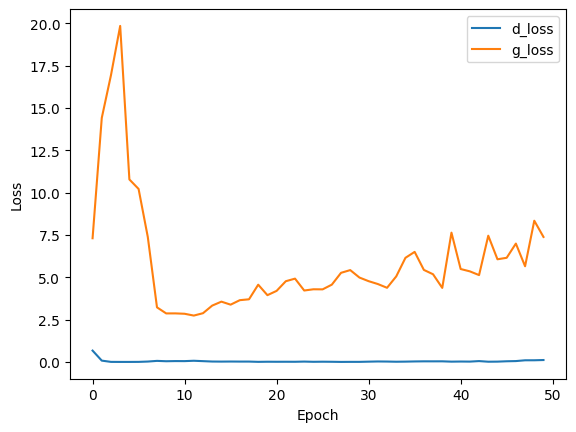

In [ ]:
plt.plot(history.history['d_loss'], label='d_loss')
plt.plot(history.history['g_loss'], label='g_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

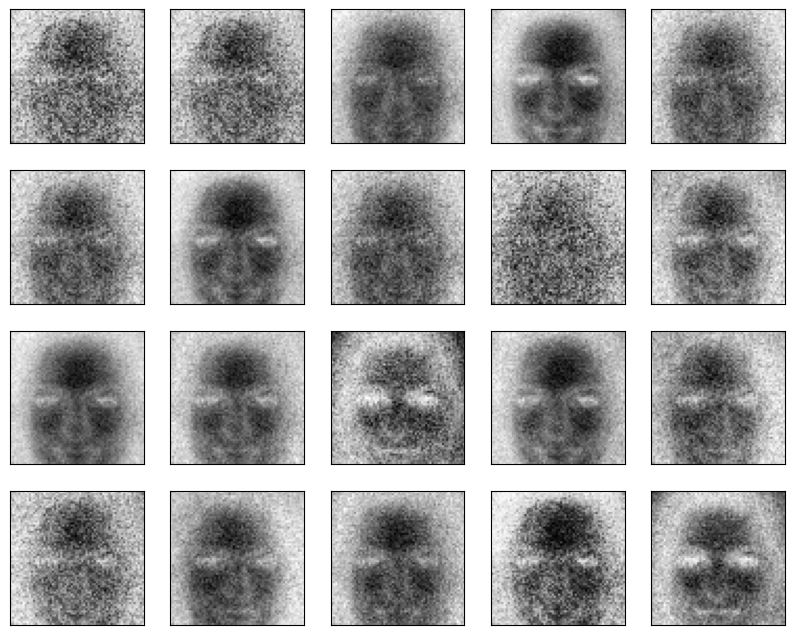

In [ ]:
random_latent_vectors = tf.random.normal(shape=(20, latent_dim))
generated_data = model.generator(random_latent_vectors)
generated_data.numpy()

plt.figure(figsize=(10,8))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(generated_data[i], cmap='binary')
    plt.xticks([])
    plt.yticks([])

plt.show()